In [78]:
correction_list = {
    "Kim K": "Kim K.",
    "Al Ghareeb M.": "Al-Ghareeb M.",
    "Al Khulaifi N.G.": "Al-Khulaifi N.G.",
    "Alawadhi O.": "Al-Awadhi O.",
    "Bahrouzyan O.": "Al-Awadhi O.",
    "Haji A.": "Al-Haji A.",
    "Hajji A.": "Al-Haji A.",
    "El Aarej M.": "El-Aarej M.",
    "El Amrani R.": "El-Amrani R.",
    "El Aynaoui Y.": "El-Aynaoui Y.",
    "Granollers Pujol G.": "Granollers-Pujol G.",
    "Granollers G.": "Granollers-Pujol G.",
    "Granollers M.": "Granollers-Pujol M.",
    "Al Mutawa J.": "Ali Mutawa J.M.",
    "Al-Mutawa J.": "Ali Mutawa J.M.",
    "Bogomolov Jr. A.": "Bogomolov Jr.A.",
    "Bogomolov A.": "Bogomolov Jr.A.",
    "Carreno Busta": "Carreno-Busta",
    "Chela J.": "Chela J.I.",
    "Dutra Silva R.": "Dutra da Silva R.",
    "Dutra Da Silva R.": "Dutra da Silva R.",
    "Ferrero J.": "Ferrero J.C.",
    "Gambill J. M.": "Gambill J.M.",
    "Guzman J.": "Guzman J.P.",
    "Haider-Mauer A.": "Haider-Maurer A.",
    "Zayid M. S.": "Zayid M.S.",
    "De Bakker T.": "de Bakker T.",
    "De Chaunac S.": "de Chaunac S.",
    "De Greef A.": "de Greef A.",
    "De Heart R.": "de Heart R.",
    "De Loore J.": "de Loore J.",
    "De Minaur A.": "de Minaur A.",
    "De Schepper K.": "de Schepper K.",
    "De Voest R.": "de Voest R.",
    "Del Bonis F.": "del Bonis F.",
    "Del Potro J.": "del Potro J.M.",
    "Del Potro J. M.": "del Potro J.M.",
    "Del Potro J.M.": "del Potro J.M.",
    "Van D. Merwe I.": "van D. Merwe I.",
    "Van Der Merwe I.": "van Der Merwe I.",
    "Van Lottum J.": "van Lottum J.",
    "Van Rijthoven T.": "van Rijthoven T.",
    "Van der Dium A.": "van der Dium A.",
    "Van der Merwe I.": "van der Merwe I.",
    "Munoz De La Nava D.": "Munoz de la Nava D.",
    "Munoz de La Nava D.": "Munoz de la Nava D.",
    "Munoz-De La Nava D.": "Munoz de la Nava D.",
    "Di Mauro A.": "di Mauro A.",
    "Di Pasquale A.": "di Pasquale A.",
}

drop_list = ["W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5", "Wsets", "Lsets", "CBW", "CBL", "GBW", "GBL", "IWW", "IWL", "SBW", "SBL", "B&WW", "B&WL", "EXW", "EXL", "UBW", "UBL", "LBW", "LBL", "SJW", "SJL", "MaxW", "MaxL", "AvgW", "AvgL", "WRank", "LRank"]

Let's download, save, cleanup, and agregate the data into a dataframe and and save it to a csv file. We also caculate the elo rate of each player right before the game as well as the probability for the winner to win the game based on the elo rates of the two players.

In [79]:
import pandas as pd
import requests
import io
import datetime

# Download the data
url_base = "http://tennis-data.co.uk/"

sess = requests.session()
df_list = []
for year in range(2000, 2013):
    url = f"{url_base}/{year}/{year}.xls"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xls", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))

for year in range(2013, datetime.datetime.now().year+1):
    url = f"{url_base}/{year}/{year}.xlsx"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xlsx", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))
sess.close()

# Put the downloaded data together
df_atp = pd.concat(df_list, axis=0).drop(labels=drop_list, axis=1) 

# Cleanup the data
df_atp["Winner"] = df_atp["Winner"].str.strip()
df_atp["Loser"] = df_atp["Loser"].str.strip()

df_atp["Winner"] = df_atp["Winner"].replace(correction_list)
df_atp["Loser"] = df_atp["Loser"].replace(correction_list)

df_atp["Best of"] = pd.to_numeric(df_atp["Best of"], errors="coerce", downcast="integer")
df_atp["WPts"] = pd.to_numeric(df_atp["WPts"], errors="coerce", downcast="integer")
df_atp["LPts"] = pd.to_numeric(df_atp["LPts"], errors="coerce", downcast="integer")

df_atp["Date"] = pd.to_datetime(df_atp["Date"])

# Calculate the elo rate and number of played matches for each player at the begining of the match.
# Also calculate the probability for the winner of the game to win the game based on the elo rates
elo_start = 1500.0
k_factor = 32.0

df_atp[["match_count_winner", "match_count_loser"]] = 0
df_atp[["elo_winner", "elo_loser"]] = elo_start
df_atp["proba_elo"] = .5

df_atp = df_atp.sort_values(by=["ATP", "Date"]).reset_index(drop=True).copy()

elo_rates = pd.DataFrame(data={"Player": pd.concat([df_atp["Winner"], df_atp["Loser"]], axis=0).unique(),"match_count":  0, "elo": elo_start})
for index, _ in df_atp.iterrows():
    # Set the current elo rate/match count for the winner and loser of the match
    df_atp.loc[index, "elo_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"].values[0]
    df_atp.loc[index, "elo_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"].values[0]
    df_atp.loc[index, "match_count_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "match_count"].values[0]
    df_atp.loc[index, "match_count_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "match_count"].values[0]

    # Set the probability of the outcome based on the elo rates
    df_atp.loc[index, "proba_elo"] = 1.0/(1.0 + 10.0**(.0025*(df_atp.loc[index, "elo_loser"] - df_atp.loc[index, "elo_winner"])))

    # Update the elo scores/match counts based on the outcome of the match
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"] += k_factor*(1.0 - df_atp.loc[index, "proba_elo"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"] -= k_factor*(1.0 - df_atp.loc[index, "proba_elo"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "match_count"] += 1
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "match_count"] += 1

# Save the result in respective files
df_atp.to_csv("archive/atp_data.csv")
elo_rates.to_csv("archive/elo_rates.csv")

In [80]:
court_surface_type = df_atp[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()

try:
    elo_start
except NameError:
    elo_start = 1500.0
    k_factor = 32.0

# Initialize new columns in datasets
for pair in court_surface_type:
    col_name = f"{pair[0].lower()}_{pair[1].lower()}"
    df_atp[[f"match_count_{col_name}_winner", f"match_count_{col_name}_loser"]] = 0
    df_atp[[f"elo_{col_name}_winner", f"elo_{col_name}_loser"]] = elo_start
    df_atp[f"proba_elo_{col_name}"] = .5
    

    elo_rates[f"match_count_{col_name}"] = 0
    elo_rates[f"elo_{col_name}"] = elo_start

# Add the field specific elo rates and played match count of the players
for index, _ in df_atp.iterrows():
    field_type = f"{df_atp.loc[index, 'Court'].lower()}_{df_atp.loc[index, 'Surface'].lower()}"
    for pair in court_surface_type:
        col_name = f"{pair[0].lower()}_{pair[1].lower()}"

        # Set the current match count for the winner and loser of the match (court/surface specific)
        df_atp.loc[index, f"match_count_{col_name}_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"match_count_{col_name}"].values[0]
        df_atp.loc[index, f"match_count_{col_name}_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"match_count_{col_name}"].values[0]

        # Set the current elo rate of the winner and loser of the match (court/surface specific)
        df_atp.loc[index, f"elo_{col_name}_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"elo_{col_name}"].values[0]
        df_atp.loc[index, f"elo_{col_name}_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"elo_{col_name}"].values[0]
        
        # Set the probability of the outcome based on the elo rates (court/surface specific)
        df_atp.loc[index, f"proba_elo_{col_name}"] = 1.0/(1.0 + 10.0**(.0025*(df_atp.loc[index, f"elo_{col_name}_loser"] - df_atp.loc[index, f"elo_{col_name}_winner"])))
    
    # Update match counts based on the outcome of the match (court/surface specific)
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"match_count_{field_type}"] += 1
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"match_count_{field_type}"] += 1

    # Update elo rates based on the outcome of the match (court/surface specific)
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"elo_{field_type}"] += k_factor*(1.0 - df_atp.loc[index, f"proba_elo_{field_type}"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"elo_{field_type}"] -= k_factor*(1.0 - df_atp.loc[index, f"proba_elo_{field_type}"])
    

# Drop the rows in which the point of the players are absent
df_atp.dropna(subset=["WPts", "LPts"], axis=0, inplace=True)

# Save the new dataset (enriched dataset)
df_atp.to_csv("archive/atp_data_enriched.csv")
elo_rates.to_csv("archive/elo_rates_enriched.csv")

# Show its info
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47924 entries, 186 to 64207
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ATP                               47924 non-null  int64         
 1   Location                          47924 non-null  object        
 2   Tournament                        47924 non-null  object        
 3   Date                              47924 non-null  datetime64[ns]
 4   Series                            47924 non-null  object        
 5   Court                             47924 non-null  object        
 6   Surface                           47924 non-null  object        
 7   Round                             47924 non-null  object        
 8   Best of                           47909 non-null  float64       
 9   Winner                            47924 non-null  object        
 10  Loser                             47924 non-null 

In [2]:
import pandas as pd

# Load data from the disk
elo_rates = pd.read_csv("archive/elo_rates_enriched.csv", dtype={"Player": "object", "match_count": "int64", "elo": "float64"}, index_col=0)
df_atp = pd.read_csv("archive/atp_data_enriched.csv", index_col=0)
# df_conf = pd.read_csv("archive/confidence_data.csv")

df_atp["Date"] = pd.to_datetime(df_atp["Date"])

# Drop 350 rows where bet odds are absent
df_atp_reduced = df_atp.dropna(subset=["PSW", "PSL", "B365W", "B365L"], axis=0)

# Show the info
df_atp_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44574 entries, 186 to 64207
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ATP                               44574 non-null  int64         
 1   Location                          44574 non-null  object        
 2   Tournament                        44574 non-null  object        
 3   Date                              44574 non-null  datetime64[ns]
 4   Series                            44574 non-null  object        
 5   Court                             44574 non-null  object        
 6   Surface                           44574 non-null  object        
 7   Round                             44574 non-null  object        
 8   Best of                           44559 non-null  float64       
 9   Winner                            44574 non-null  object        
 10  Loser                             44574 non-null 

In [82]:
df_atp.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,match_count_outdoor_clay_winner,match_count_outdoor_clay_loser,elo_outdoor_clay_winner,elo_outdoor_clay_loser,proba_elo_outdoor_clay,match_count_outdoor_grass_winner,match_count_outdoor_grass_loser,elo_outdoor_grass_winner,elo_outdoor_grass_loser,proba_elo_outdoor_grass
64203,68,Turin,Masters Cup,2022-11-18,Masters Cup,Indoor,Hard,Round Robin,NaN,Djokovic N.,...,327,54,1945.836747,1548.326690,0.907899,128,60,2031.642431,1669.640108,0.889324
64204,68,Turin,Masters Cup,2022-11-18,Masters Cup,Indoor,Hard,Round Robin,NaN,Rublev A.,...,100,123,1690.460706,1807.273558,0.337953,27,35,1625.000143,1597.077705,0.540097
64205,68,Turin,Masters Cup,2022-11-19,Masters Cup,Indoor,Hard,Semifinals,NaN,Djokovic N.,...,327,64,1945.836747,1568.776712,0.897572,128,44,2031.642431,1571.271783,0.934018
64206,68,Turin,Masters Cup,2022-11-19,Masters Cup,Indoor,Hard,Semifinals,NaN,Ruud C.,...,175,100,1769.315045,1690.460706,0.611571,12,27,1454.898202,1625.000143,0.273053
64207,68,Turin,Masters Cup,2022-11-20,Masters Cup,Indoor,Hard,The Final,NaN,Djokovic N.,...,327,175,1945.836747,1769.315045,0.734220,128,12,2031.642431,1454.898202,0.965109


In [83]:
df_atp_reduced[["PSW", "PSL", "B365W", "B365L"]].describe()

,PSW,PSL,B365W,B365L
count,44574.000000,44574.000000,44574.000000,44574.000000
mean,1.931947,4.054946,1.841453,3.553417
std,1.306077,5.165281,1.148371,3.523612
min,0.972000,1.010000,0.971000,0.967000
25%,1.280000,1.781000,1.250000,1.720000
50%,1.560000,2.620000,1.500000,2.500000
75%,2.160000,4.150000,2.100000,4.000000
max,46.000000,121.000000,34.000000,67.000000


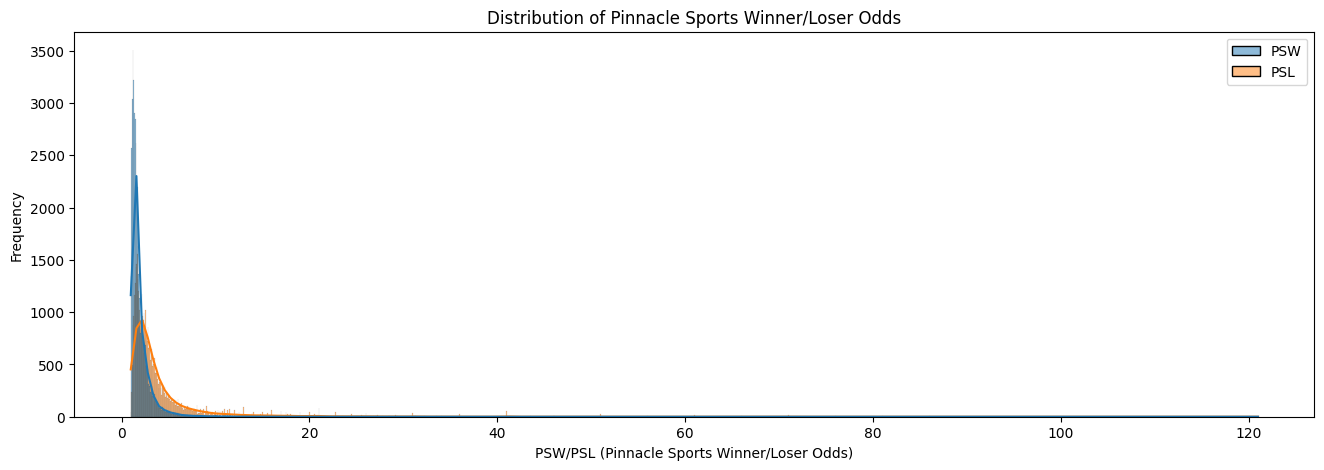

They max on 46.0 (for winners) and 121.0 (for losers).


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of Pinnacle Sports' bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(df_atp_reduced[["PSW", "PSL"]], kde=True, color=[["green"], ["red"]])

# Add labels and title
plt.title('Distribution of Pinnacle Sports Winner/Loser Odds')
plt.xlabel('PSW/PSL (Pinnacle Sports Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {df_atp_reduced['PSW'].max()} (for winners) and {df_atp_reduced['PSL'].max()} (for losers).")

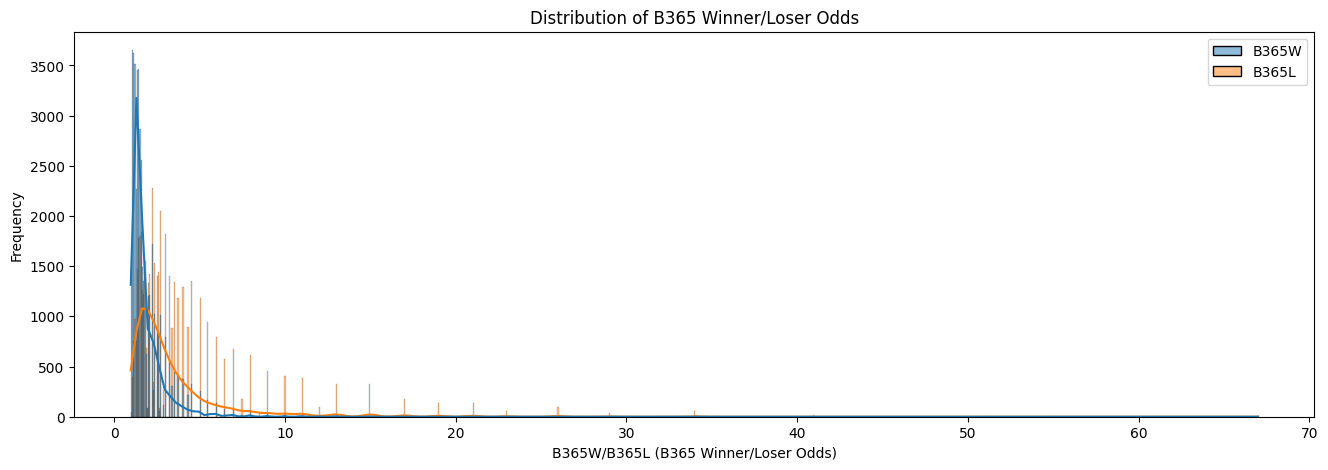

They max on 34.0 (for winners) and 67.0 (for losers).


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of B365 bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(df_atp_reduced[["B365W", "B365L"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of B365 Winner/Loser Odds')
plt.xlabel('B365W/B365L (B365 Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {df_atp_reduced['B365W'].max()} (for winners) and {df_atp_reduced['B365L'].max()} (for losers).")

# Top 10 players over all (without considering the field type):

In [86]:
print(f"Top 10 players over all (without considering the field type):")
elo_rates[["Player", "match_count", "elo"]].sort_values(by="elo", ascending=False).iloc[:10]

Top 10 players over all (without considering the field type):


,Player,match_count,elo
84,Djokovic N.,1243,2023.493521
3,Federer R.,1442,1986.276718
80,Murray A.,951,1941.993440
446,Nalbandian D.,541,1927.284331
8,Hewitt L.,727,1900.525724
199,Sinner J.,261,1893.662852
204,Rune H.,155,1892.928993
427,Alcaraz C.,195,1888.417184
85,del Potro J.M.,587,1883.029153
127,Dimitrov G.,682,1875.425925


# Top 10 players in indoor courts and on hard surfaces:

In [87]:
index = 0
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on hard surfaces:


,Player,match_count_indoor_hard,elo_indoor_hard
84,Djokovic N.,193,1944.653909
3,Federer R.,251,1882.914144
80,Murray A.,163,1865.597653
85,del Potro J.M.,115,1802.235731
204,Rune H.,44,1800.965595
446,Nalbandian D.,63,1775.532770
127,Dimitrov G.,137,1767.851989
482,Zverev A.,104,1758.167533
199,Sinner J.,73,1755.345099
98,Soderling R.,116,1740.821244


# Top 10 players in indoor courts and on carpet surfaces:

In [88]:
index = 1
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on carpet surfaces:


,Player,match_count_indoor_carpet,elo_indoor_carpet
446,Nalbandian D.,45,1743.530935
448,Safin M.,64,1725.213894
3,Federer R.,60,1678.953410
370,Kafelnikov Y.,37,1669.796325
38,Davydenko N.,57,1664.012327
7,Henman T.,37,1659.057469
80,Murray A.,24,1645.667525
98,Soderling R.,29,1643.943041
233,Youzhny M.,62,1640.301804
106,Roddick A.,36,1632.421053


# Top 10 players in indoor courts and on clay surfaces:

In [89]:
index = 2
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on clay surfaces:


,Player,match_count_indoor_clay,elo_indoor_clay
325,Cuevas P.,19,1625.072438
321,Jarry N.,12,1578.487585
320,Pella G.,14,1573.177593
479,Garin C.,14,1571.159831
152,Nadal R.,4,1567.504325
516,Ruud C.,10,1563.889683
181,Fognini F.,11,1563.143787
446,Nalbandian D.,8,1561.387034
728,Seyboth Wild T.,10,1554.128924
480,Delbonis F.,22,1552.233578


# Top 10 players in outdoor courts and on hard surfaces:

In [90]:
index = 3
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on hard surfaces:


,Player,match_count_outdoor_hard,elo_outdoor_hard
84,Djokovic N.,582,2150.268703
3,Federer R.,638,2065.545468
80,Murray A.,478,1939.811708
152,Nadal R.,535,1936.510644
161,Medvedev D.,222,1890.582531
541,Sampras P.,91,1875.729444
427,Alcaraz C.,84,1867.604565
85,del Potro J.M.,295,1861.554435
199,Sinner J.,104,1859.818892
535,Agassi A.,207,1853.118641


# Top 10 players in outdoor courts and on clay surfaces:

In [91]:
index = 4
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on clay surfaces:


,Player,match_count_outdoor_clay,elo_outdoor_clay
152,Nadal R.,500,2114.770659
84,Djokovic N.,327,1945.836747
80,Murray A.,151,1932.826518
427,Alcaraz C.,73,1858.455370
85,del Potro J.M.,112,1849.828203
100,Nishikori K.,151,1832.345763
3,Federer R.,280,1819.657570
318,Tsitsipas S.,123,1807.273558
98,Soderling R.,120,1806.470828
451,Kuerten G.,145,1797.159425


# Top 10 players in outdoor courts and on grass surfaces:

In [92]:
index = 5
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on grass surfaces:


,Player,match_count_outdoor_grass,elo_outdoor_grass
84,Djokovic N.,128,2031.642431
3,Federer R.,213,1983.267325
152,Nadal R.,97,1843.355226
80,Murray A.,135,1829.604428
130,Cilic M.,110,1819.177954
106,Roddick A.,103,1767.299838
72,Berdych T.,98,1766.786125
139,Raonic M.,74,1754.255720
8,Hewitt L.,134,1749.842855
94,Tsonga J.W.,72,1747.980698


# It's time to define some betting strategies:
1. To bet on the higher ranked player (HPBS)
2. To bet on the lower ranked player (LPBS)
3. To bet on the player with higher total elo rate (HRBS)
4. To bet on the player with lower total elo rate (LRBS)
5. To bet on the player with the better elo rate in the appropirate field type (BRFTBS)
6. To bet on a random player (RPBS)
7. To bet on the winner always (WBS)
8. To bet on the loser always (LBS)

Ofcourse, the strategies 5 and 6 are just theoretical and put there to compare the strategies with the theoretical maximum profit.

In [3]:
import numpy as np

profit = df_atp_reduced[["Court", "Surface", "Winner", "Loser", "WPts", "LPts", "PSW", "B365W", "proba_elo", "proba_elo_indoor_hard", "proba_elo_indoor_clay", "proba_elo_indoor_carpet", "proba_elo_outdoor_hard", "proba_elo_outdoor_clay", "proba_elo_outdoor_grass"]].copy()

# Strategy 1
strategies = pd.DataFrame(df_atp["WPts"] > df_atp["LPts"], columns=["HPBS"], index=df_atp_reduced.index)
profit[["HPBS_PS", "HPBS_B365"]] = profit.loc[strategies["HPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "HPBS_PS", "B365W": "HPBS_B365"}) - 1.0

# Strategy 2
strategies["LPBS"] = df_atp["WPts"] < df_atp["LPts"]
profit[["LPBS_PS", "LPBS_B365"]] = profit.loc[strategies["LPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LPBS_PS", "B365W": "LPBS_B365"}) - 1.0

# Strategy 3
strategies["HRBS"] = df_atp["elo_winner"] > df_atp["elo_loser"]
profit[["HRBS_PS", "HRBS_B365"]] = profit.loc[strategies["HRBS"], ["PSW", "B365W"]].rename(columns={"PSW": "HRBS_PS", "B365W": "HRBS_B365"}) - 1.0

# Strategy 4
strategies["LRBS"] = df_atp["elo_winner"] < df_atp["elo_loser"]
profit[["LRBS_PS", "LRBS_B365"]] = profit.loc[strategies["LRBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LRBS_PS", "B365W": "LRBS_B365"}) - 1.0

# Strategy 5
court_surface_type = df_atp[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()
strategies["BRFTBS"] = False
for pair in court_surface_type:
    col_name = f"proba_elo_{pair[0].lower()}_{pair[1].lower()}"
    strategies.loc[(profit["Court"]==pair[0]) & (profit["Surface"]==pair[1]), "BRFTBS"] = profit.loc[(profit["Court"]==pair[0]) & (profit["Surface"]==pair[1]), col_name] >= .5
profit[["BRFTBS_PS", "BRFTBS_B365"]] = profit.loc[strategies["BRFTBS"], ["PSW", "B365W"]].rename(columns={"PSW": "BRFTBS_PS", "B365W": "BRFTBS_B365"}) - 1.0

# Strategy 6
np.random.seed(13572)
strategies["RPBS"] = np.random.randint(0, 2, size=len(strategies))==1
profit[["RPBS_PS", "RPBS_B365"]] = profit.loc[strategies["RPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "RPBS_PS", "B365W": "RPBS_B365"}) - 1.0

# Strategy 7
strategies["WBS"] = True
profit[["WBS_PS", "WBS_B365"]] = profit.loc[strategies["WBS"], ["PSW", "B365W"]].rename(columns={"PSW": "WBS_PS", "B365W": "WBS_B365"}) - 1.0

# Strategy 8
strategies["LBS"] = False
profit[["LBS_PS", "LBS_B365"]] = profit.loc[strategies["LBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LBS_PS", "B365W": "LBS_B365"}) - 1.0

# profit.dropna(axis=0, subset=["PSW", "B365W"], inplace=True)
profit.fillna(value=-1.0, inplace=True)

profit.head(10)

,Court,Surface,Winner,Loser,WPts,LPts,PSW,B365W,proba_elo,proba_elo_indoor_hard,...,LRBS_PS,LRBS_B365,BRFTBS_PS,BRFTBS_B365,RPBS_PS,RPBS_B365,WBS_PS,WBS_B365,LBS_PS,LBS_B365
186,Outdoor,Hard,Berdych T.,Calleri A.,1200.0,692.0,1.446,1.39,0.467894,0.5,...,0.446,0.39,-1.000,-1.00,0.446,0.39,0.446,0.39,-1.0,-1.0
187,Outdoor,Hard,Kohlschreiber P.,Guccione C.,470.0,265.0,1.719,1.53,0.476990,0.5,...,0.719,0.53,-1.000,-1.00,0.719,0.53,0.719,0.53,-1.0,-1.0
188,Outdoor,Hard,Malisse X.,Luczak P.,731.0,286.0,1.391,1.28,0.503898,0.5,...,-1.000,-1.00,0.391,0.28,0.391,0.28,0.391,0.28,-1.0,-1.0
189,Outdoor,Hard,Robredo T.,Melzer J.,1490.0,690.0,1.606,1.53,0.513534,0.5,...,-1.000,-1.00,0.606,0.53,0.606,0.53,0.606,0.53,-1.0,-1.0
190,Outdoor,Hard,Ancic M.,Clement A.,1360.0,558.0,1.549,1.44,0.516288,0.5,...,-1.000,-1.00,0.549,0.44,-1.000,-1.00,0.549,0.44,-1.0,-1.0
191,Outdoor,Hard,Mayer F.,Monaco J.,519.0,477.0,1.606,1.50,0.500014,0.5,...,-1.000,-1.00,0.606,0.50,0.606,0.50,0.606,0.50,-1.0,-1.0
192,Outdoor,Hard,Seppi A.,Pashanski B.,562.0,498.0,1.524,1.40,0.500000,0.5,...,-1.000,-1.00,0.524,0.40,0.524,0.40,0.524,0.40,-1.0,-1.0
193,Outdoor,Hard,Philippoussis M.,Spadea V.,228.0,515.0,1.877,1.83,0.569668,0.5,...,-1.000,-1.00,0.877,0.83,0.877,0.83,0.877,0.83,-1.0,-1.0
194,Outdoor,Hard,Karlovic I.,Chela J.I.,550.0,815.0,2.210,1.90,0.427706,0.5,...,1.210,0.90,-1.000,-1.00,1.210,0.90,1.210,0.90,-1.0,-1.0
195,Outdoor,Hard,Blake J.,Martin A.,1230.0,711.0,1.163,1.12,0.437766,0.5,...,0.163,0.12,-1.000,-1.00,-1.000,-1.00,0.163,0.12,-1.0,-1.0


# This is how each strategy would perform:

In [94]:
print("The statistics related to bet strategies on \"Pinnacle Sports\"")
profit[["HPBS_PS", "LPBS_PS", "HRBS_PS", "LRBS_PS", "BRFTBS_PS", "RPBS_PS", "WBS_PS", "LBS_PS"]].describe()

The statistics related to bet strategies on "Pinnacle Sports"


,HPBS_PS,LPBS_PS,HRBS_PS,LRBS_PS,BRFTBS_PS,RPBS_PS,WBS_PS,LBS_PS
count,44574.000000,44574.000000,44574.000000,44574.000000,44574.000000,44574.000000,44574.000000,44574.0
mean,-0.032751,-0.036558,-0.005097,-0.065557,0.003520,-0.031305,0.931947,-1.0
std,0.793309,1.715414,0.871316,1.676398,0.925253,1.361203,1.306077,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.028000,-1.0
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.280000,-1.0
50%,0.181000,-1.000000,0.180000,-1.000000,0.170000,0.010000,0.560000,-1.0
75%,0.470000,0.830000,0.500000,0.710000,0.510000,0.560000,1.160000,-1.0
max,8.150000,45.000000,11.420000,45.000000,20.000000,45.000000,45.000000,-1.0


In [95]:
print("The statistics related to bet strategies on \"Bet 365\"")
profit[["HPBS_B365", "LPBS_B365", "HRBS_B365", "LRBS_B365", "BRFTBS_B365", "RPBS_B365", "WBS_B365", "LBS_B365"]].describe()

The statistics related to bet strategies on "Bet 365"


,HPBS_B365,LPBS_B365,HRBS_B365,LRBS_B365,BRFTBS_B365,RPBS_B365,WBS_B365,LBS_B365
count,44574.000000,44574.000000,44574.000000,44574.000000,44574.000000,44574.000000,44574.000000,44574.0
mean,-0.064705,-0.095050,-0.039157,-0.121869,-0.031254,-0.077360,0.841453,-1.0
std,0.818634,1.530859,0.883560,1.493180,0.927438,1.235294,1.148371,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.029000,-1.0
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.250000,-1.0
50%,0.140000,-1.000000,0.140000,-1.000000,0.140000,0.002000,0.500000,-1.0
75%,0.400000,0.720000,0.440000,0.610000,0.440000,0.500000,1.100000,-1.0
max,33.000000,28.000000,33.000000,28.000000,33.000000,33.000000,33.000000,-1.0


In [4]:
import pandas as pd
import numpy as np
import sklearn.model_selection

# Each cell in the dataframe features answers to the question whether the specified strategy predicts that player one wins
# Before constructing the dataframe we should scramble the players so that sometimes player 1 wins and he loses the other times with equal probabilities.
court_surface_type = df_atp_reduced[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()
np.random.seed(98245)
features = pd.DataFrame(np.random.randint(0, 2, size=len(df_atp_reduced))==1, columns=["P1==Winner"], index=df_atp_reduced.index)
features["P1_wins_proba_elo"] = ((1.0 - features["P1==Winner"]) - df_atp_reduced["proba_elo"]).abs()
features["P1_match_count"] = pd.merge(df_atp_reduced.loc[features["P1==Winner"], "match_count_winner"], df_atp_reduced.loc[~features["P1==Winner"], "match_count_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
features["P2_match_count"] = pd.merge(df_atp_reduced.loc[~features["P1==Winner"], "match_count_winner"], df_atp_reduced.loc[features["P1==Winner"], "match_count_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
features["P1_pts"] = pd.merge(df_atp_reduced.loc[features["P1==Winner"], "WPts"], df_atp_reduced.loc[~features["P1==Winner"], "LPts"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
features["P2_pts"] = pd.merge(df_atp_reduced.loc[~features["P1==Winner"], "WPts"], df_atp_reduced.loc[features["P1==Winner"], "LPts"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")

for pair in court_surface_type:
    field_type = f"{pair[0].lower()}_{pair[1].lower()}"
    features[f"field_type=={field_type}"] = (df_atp_reduced["Court"].str.lower() + "_" + df_atp_reduced["Surface"].str.lower() == field_type) + 0
    features[f"P1_match_count_{field_type}"] = pd.merge(df_atp_reduced.loc[features["P1==Winner"], f"match_count_{field_type}_winner"], df_atp_reduced.loc[~features["P1==Winner"], f"match_count_{field_type}_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
    features[f"P2_match_count_{field_type}"] = pd.merge(df_atp_reduced.loc[~features["P1==Winner"], f"match_count_{field_type}_winner"], df_atp_reduced.loc[features["P1==Winner"], f"match_count_{field_type}_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
    features[f"P1_wins_proba_elo_{field_type}"] = ((1.0 - features["P1==Winner"]) - df_atp_reduced[f"proba_elo_{field_type}"]).abs()
    
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features.drop(labels=["P1==Winner"], axis=1), features["P1==Winner"], test_size=0.2, random_state=42)

features.tail()

,P1==Winner,P1_wins_proba_elo,P1_match_count,P2_match_count,P1_pts,P2_pts,field_type==indoor_hard,P1_match_count_indoor_hard,P2_match_count_indoor_hard,P1_wins_proba_elo_indoor_hard,...,P2_match_count_outdoor_hard,P1_wins_proba_elo_outdoor_hard,field_type==outdoor_clay,P1_match_count_outdoor_clay,P2_match_count_outdoor_clay,P1_wins_proba_elo_outdoor_clay,field_type==outdoor_grass,P1_match_count_outdoor_grass,P2_match_count_outdoor_grass,P1_wins_proba_elo_outdoor_grass
64203,False,0.252786,444,1240,4065,3320,1,108,190,0.202169,...,582,0.183191,0,54,327,0.092101,0,60,128,0.110676
64204,True,0.301900,425,419,3530,5350,1,100,98,0.300160,...,163,0.469776,0,100,123,0.337953,0,27,35,0.540097
64205,True,0.863992,1241,379,3320,2955,1,191,51,0.890563,...,220,0.937717,0,327,64,0.897572,0,128,44,0.934018
64206,False,0.632670,426,322,3530,5020,1,101,29,0.623226,...,95,0.658726,0,100,175,0.388429,0,27,12,0.726947
64207,True,0.881619,1242,323,3320,5020,1,192,30,0.898019,...,95,0.956225,0,327,175,0.734220,0,128,12,0.965109


In [97]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44574 entries, 186 to 64207
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   P1==Winner                       44574 non-null  bool   
 1   P1_wins_proba_elo                44574 non-null  float64
 2   P1_match_count                   44574 non-null  int64  
 3   P2_match_count                   44574 non-null  int64  
 4   P1_pts                           44574 non-null  int64  
 5   P2_pts                           44574 non-null  int64  
 6   field_type==indoor_hard          44574 non-null  int64  
 7   P1_match_count_indoor_hard       44574 non-null  int64  
 8   P2_match_count_indoor_hard       44574 non-null  int64  
 9   P1_wins_proba_elo_indoor_hard    44574 non-null  float64
 10  field_type==indoor_carpet        44574 non-null  int64  
 11  P1_match_count_indoor_carpet     44574 non-null  int64  
 12  P2_match_count_indoor

In [5]:
import pandas as pd
import numpy as np
import sklearn.ensemble

model_rfc = sklearn.ensemble.RandomForestClassifier(max_depth=15, random_state=26895645)
model_rfc.fit(X_train, y_train)
rfc_result = pd.DataFrame({"rfc_result": ~np.logical_xor(model_rfc.predict(X_test), y_test), "rfc_proba_P1_wins": model_rfc.predict_proba(X_test)[:, 1]}, index=y_test.index)

print(f"Random forest with the given features can predict correctly with the probability of {round(model_rfc.score(X_test, y_test)*100, 2)} %")
profits_test = pd.DataFrame({"rfc_result": 0 + rfc_result["rfc_result"], "rfc_profit_PS": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "rfc_profit_B365": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)
profits_test.describe()

Random forest with the given features can predict correctly with the probability of 66.58 %


,rfc_result,rfc_profit_PS,rfc_profit_B365
count,8915.000000,8915.000000,8915.000000
mean,0.665844,-0.004273,-0.037265
std,0.471721,0.796785,0.817594
min,0.000000,-1.000000,-1.000000
25%,0.000000,-1.000000,-1.000000
50%,1.000000,0.200000,0.160000
75%,1.000000,0.485000,0.440000
max,1.000000,6.150000,28.000000


In [7]:
import pandas as pd
import numpy as np
import sklearn

model_dtc = sklearn.tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
model_dtc_abc = sklearn.ensemble.AdaBoostClassifier(estimator=model_dtc, learning_rate=1e-2, n_estimators=1500, algorithm="SAMME", random_state=26645)
model_dtc_abc.fit(X_train, y_train)
dtc_abc_result = pd.DataFrame({"dtc_abc_result": ~np.logical_xor(model_dtc_abc.predict(X_test), y_test), "dtc_abc_proba_P1_wins": model_dtc_abc.predict_proba(X_test)[:, 1]}, index=y_test.index)

print(f"Decision tree with Ada boost algorithm with the given features can predict correctly with the probability of {round(model_dtc_abc.score(X_test, y_test)*100, 2)} %")
profits_test[["dtc_abc_result", "dtc_abc_profit_PS", "dtc_abc_profit_B365"]] = pd.DataFrame({"dtc_abc_result": 0 + dtc_abc_result["dtc_abc_result"], "dtc_abc_profit_PS": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "dtc_abc_profit_B365": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)
profits_test.describe()

Decision tree with Ada boost algorithm with the given features can predict correctly with the probability of 67.44 %


,rfc_result,rfc_profit_PS,rfc_profit_B365,nn_result,nn_profit_PS,nn_profit_B365,dtc_abc_result,dtc_abc_profit_PS,dtc_abc_profit_B365
count,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000
mean,0.665844,-0.004273,-0.037265,0.657656,-0.013255,-0.045631,0.674369,0.001316,-0.031515
std,0.471721,0.796785,0.817594,0.474521,0.809698,0.829478,0.468636,0.776837,0.801563
min,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
50%,1.000000,0.200000,0.160000,1.000000,0.190000,0.160000,1.000000,0.210000,0.160000
75%,1.000000,0.485000,0.440000,1.000000,0.480000,0.400000,1.000000,0.490000,0.440000
max,1.000000,6.150000,28.000000,1.000000,6.150000,28.000000,1.000000,5.620000,28.000000


In [8]:
import tensorflow as tf

# Define the model
model_nn = tf.keras.models.Sequential()

# Add layers to the model
model_nn.add(tf.keras.layers.Dense(40, input_dim=29, activation='relu'))    # Input layer with 29 features
model_nn.add(tf.keras.layers.Dense(25, activation='sigmoid'))               # Hidden layer
model_nn.add(tf.keras.layers.Dense(10, activation='sigmoid'))               # Hidden layer
model_nn.add(tf.keras.layers.Dense(4, activation='sigmoid'))                # Hidden layer
model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))                # Output layer with sigmoid activation for binary classification

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
# model_nn.summary()

model_nn.fit(X_train, y_train + 0.0, epochs=10, batch_size=2, validation_split=0.2)
nn_result = pd.DataFrame({"nn_result": ~np.logical_xor(model_nn.predict(X_test)[:, 0]>.5, y_test), "dtc_abc_proba_P1_wins": model_nn.predict(X_test)[:, 0]}, index=y_test.index)
print(f"Neural network algorithm with the given features can predict correctly with the probability of {round(model_nn.evaluate(X_test, y_test)[1]*100, 2)} %")
profits_test[["nn_result", "nn_profit_PS", "nn_profit_B365"]] = pd.DataFrame({"nn_result": 0 + nn_result["nn_result"], "nn_profit_PS": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "nn_profit_B365": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)
profits_test.describe()

Epoch 1/10
 2441/14264 [====>.........................] - ETA: 15s - loss: 0.6591 - accuracy: 0.6229

14264/14264 [==============================] - 22s 2ms/step - loss: 0.6449 - accuracy: 0.6397 - val_loss: 0.6330 - val_accuracy: 0.6496
Epoch 2/10
14264/14264 [==============================] - 22s 2ms/step - loss: 0.6378 - accuracy: 0.6288 - val_loss: 0.6380 - val_accuracy: 0.6531
Epoch 3/10
14264/14264 [==============================] - 22s 2ms/step - loss: 0.6385 - accuracy: 0.6382 - val_loss: 0.6328 - val_accuracy: 0.6381
Epoch 4/10
14264/14264 [==============================] - 21s 1ms/step - loss: 0.6269 - accuracy: 0.6509 - val_loss: 0.6269 - val_accuracy: 0.6510
Epoch 5/10
14264/14264 [==============================] - 21s 1ms/step - loss: 0.6241 - accuracy: 0.6560 - val_loss: 0.6271 - val_accuracy: 0.6531
Epoch 6/10
14264/14264 [==============================] - 22s 2ms/step - loss: 0.6246 - accuracy: 0.6495 - val_loss: 0.6263 - val_accuracy: 0.6559
Epoch 7/10
14264/14264 [==============================] - 22s 2ms/step - loss: 0.6245 - accuracy: 0.6509 - val_loss: 0.6238 - val

,rfc_result,rfc_profit_PS,rfc_profit_B365,nn_result,nn_profit_PS,nn_profit_B365,dtc_abc_result,dtc_abc_profit_PS,dtc_abc_profit_B365
count,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000
mean,0.665844,-0.004273,-0.037265,0.667639,-0.002910,-0.036277,0.674369,0.001316,-0.031515
std,0.471721,0.796785,0.817594,0.471086,0.796439,0.815771,0.468636,0.776837,0.801563
min,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
50%,1.000000,0.200000,0.160000,1.000000,0.200000,0.160000,1.000000,0.210000,0.160000
75%,1.000000,0.485000,0.440000,1.000000,0.485000,0.440000,1.000000,0.490000,0.440000
max,1.000000,6.150000,28.000000,1.000000,6.700000,28.000000,1.000000,5.620000,28.000000
